In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df_core = pd.read_csv("./data/TMA_data/panel1_data_cleaned_withCelltypes_03-29.csv")
df_map = pd.read_csv("./data/TMA_data/mapping.csv")

df_map = df_map.loc[df_map['Classification']=='Malignant', :]
df_map.loc[df_map['subtype']== "epithelial or epithelioid", 'subtype'] = "epithelioid"
# df_core2 = pd.read_csv("../Data_folder/TMA2/panel2_data_cleaned_withMarkerCelltypes.csv")

df_core2 = pd.read_csv("./data/TMA_data/panel2_data_cleaned_withCelltypes_03-29.csv")
df_density2 = pd.read_csv("./data/TMA_data/densities_tma2.csv")
df_map_density2 = pd.merge(df_map, df_density2, how='inner', on="Annotation2")

df = pd.merge(df_core, df_map, how="left", on="Annotation ID") #(781689, 197)
df2 = pd.merge(df_core2, df_map_density2, how="left", on="Annotation2")

df.dropna(subset = ['Institute'], inplace=True) #(576032, 197)  #105 MVB, 315 cores
df2.dropna(subset = ['Institute'], inplace=True) #(606114, 191) #104 MVB 304 cores

# only select the cores of df that exists id df2, df has the same core/MVB with df2
df = df.loc[df['Annotation ID'].isin(df2['Annotation ID']), :] ##104 MVB 304 cores

# completely remove other cells
df.loc[df['phenotype_combined'] == 'other', 'phenotype_combined'] = 'Unidentified'

## Phenotype composition

In [3]:
def get_marker_color(marker):
    marker_color = {"CD8": "#E41A1C",
                    "CK": "#377EB8",
                    "CD20": "#4DAF4A",
                    "CD4": "#984EA3",
                    "FOXP3": "#FF7F00",
                    "CD68": "#FFFF33",
                    "CD11c": "#A65628",
                     "CD56": "#F781BF",
                     "Unidentified": "#999999"
                    }
    return(marker_color[marker])
    
def PiePlot_combined_byPatient(data1, data2, title, order, angle=220, save=False, nolegend=False, by="MVB", casetype=None, subtype=None):

    # change_font()

    if not casetype is None:
        data1 = data1.loc[data1['CaseType'] == casetype, :]
        data2 = data2.loc[data2['CaseType'] == casetype, :]

    if not subtype is None:
        data1 = data1.loc[data1['subtype'] == subtype, :]
        data2 = data2.loc[data2['subtype'] == subtype, :]

    fc_p1 = data1.groupby([by]).apply(lambda x: x['phenotype_combined'].value_counts(
        sort=False, normalize=True).rename_axis('Type').reset_index(name='Percent'))
    fc_p2 = data2.groupby([by]).apply(lambda x: x['phenotype_combined'].value_counts(
        sort=False, normalize=True).rename_axis('Type').reset_index(name='Percent'))

    df_fc1 = fc_p1.reset_index()
    df_fc2 = fc_p2.reset_index()

    df_percent1 = df_fc1.set_index([by, 'Type'])['Percent'].unstack(
    ).reset_index()  # pivot dataframe unstack used to reshape dataframe
    df_percent2 = df_fc2.set_index([by, 'Type'])['Percent'].unstack(
    ).reset_index()  # colnames ['MVB', 'CD11c', 'CD56', 'Unidentified']
    df_percent2.drop(['other'], axis=1, inplace=True)  # delete column other
    # combine df_percent and df_percent2, deduct CD56 and CD11c percents from other in df_percent

    df_percent = pd.merge(df_percent1, df_percent2, on=by)

    df_percent['Unidentified'] = df_percent['Unidentified'] - \
        df_percent['CD56'] - df_percent['CD11c']
    # remove MVB that Unidentified < 0
    df_percent = df_percent.loc[df_percent['Unidentified'] >= 0, :]

    df_percent = df_percent.set_index(by)
    
    # df_percent.to_csv("../../Paper/Figure/NEW_ORGANIZATION/Phenotype/Composition/phenotype_percent_MVB.csv")

    percents_ave = df_percent.mean()

    s = percents_ave[order]
    new_percents = np.array(s.values)
    new_labels = ["{:.2%}".format(ele) for ele in s]

    plt.pie(new_percents, startangle=angle, labels=new_labels, textprops={'fontsize': 11},
            colors=[get_marker_color(m) for m in order],
            wedgeprops={"edgecolor": "black",
                        'linewidth': 0,
                        'antialiased': True})
    plt.ylabel('')

    if not nolegend:

        legend_labels = ['B cells(CD20)', '$\mathregular{CD4^{+}}$ T cells',
                         '$\mathregular{CD8^{+}}$ T cells', 'Treg cells (FOXP3)',
                         'Macrophages (CD68)', 'Dendritic cells (CD11c)',
                         'NK cells (CD56)', 'Pan CK cells', 'Unidentified cells']

        plt.legend(bbox_to_anchor=(1.9, 1), loc='upper right',
                   prop={'size': 11},
                   # fontname='Arial',
                   # labels=["{0}, {1:.2%}".format(l, s) for l, s in zip(new_labels, new_percents)])
                   labels=legend_labels,
                   frameon=False,
                   labelspacing=1)
    csfont = {'fontname': 'Arial'}
    plt.title(title, **csfont)

    if save:
        # plt.tight_layout()
        # plt.subplots_adjust(left=0.3, right=1, bottom=0.1, top=0.2)
        plt.savefig(
            f"../../Paper/Figure/Composition/PiePlot {title}.pdf", format='pdf', bbox_inches="tight", dpi=500)
        # plt.savefig(f"../../Paper/Figure/Composition/PiePlot {title}.png", format='png', bbox_inches = "tight", dpi=500)

    plt.show()


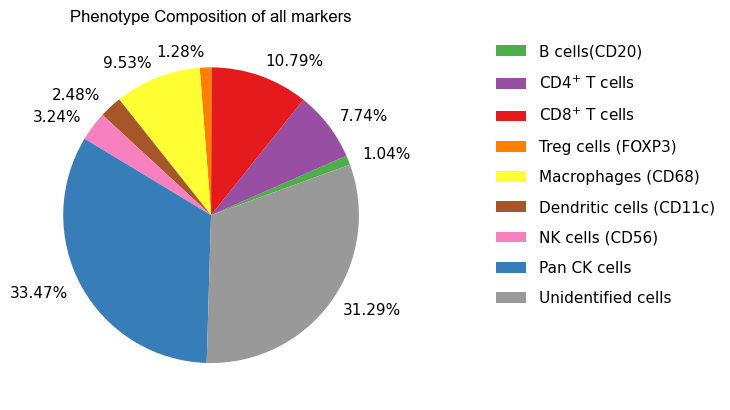

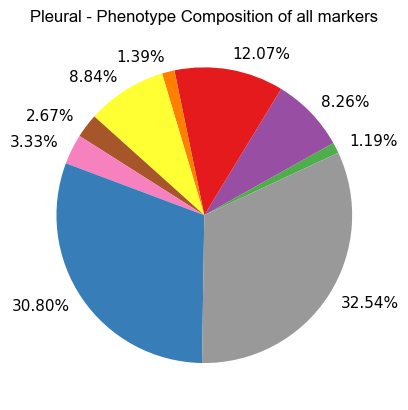

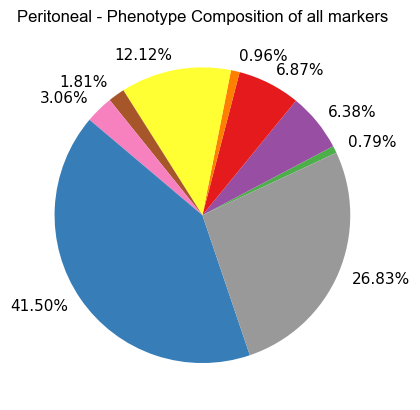

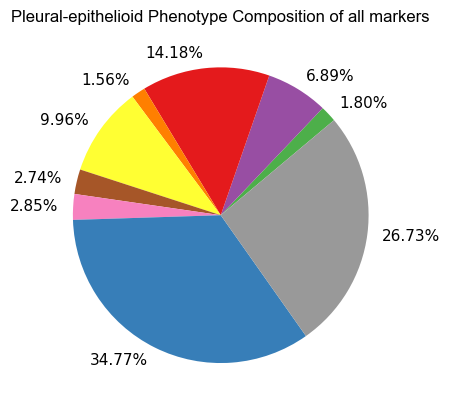

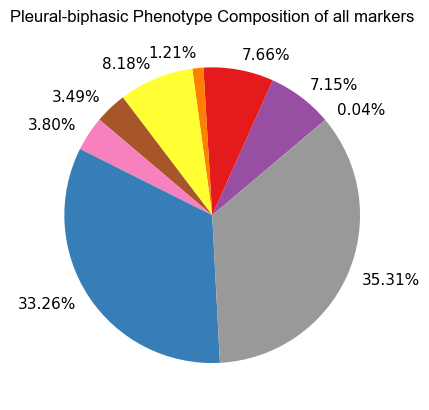

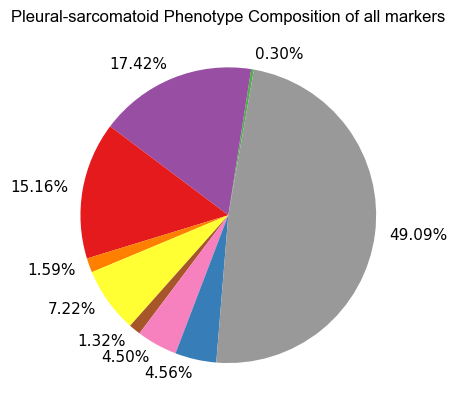

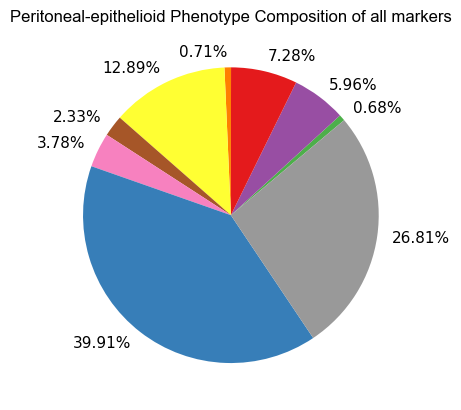

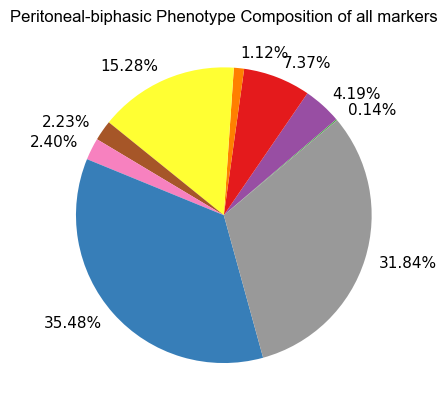

In [4]:
# composition combined by patient 
markers = ["CD20", "CD4", "CD8", "FOXP3", "CD68", "CD11c", "CD56", "CK", "Unidentified"]
title = "Phenotype Composition of all markers"
PiePlot_combined_byPatient(df,df2, title, markers, angle=20, save=False)
   
for casetype in ["Pleural", "Peritoneal"]:  
    title = f"{casetype} - Phenotype Composition of all markers"   
    PiePlot_combined_byPatient(df,df2, title, markers, angle=25, casetype = casetype, nolegend=True, save=False)  

for casetype in ["Pleural", "Peritoneal"]:  
    for subtype in ["epithelioid" ,"biphasic" ,"sarcomatoid"]:
        if casetype=="Peritoneal" and subtype=="sarcomatoid":
            next
        else:
            title = f"{casetype}-{subtype} Phenotype Composition of all markers"
            if casetype == "Pleural" and subtype=="sarcomatoid":
                angle = 80
            else:
                angle = 40
            PiePlot_combined_byPatient(df,df2, title, markers, angle=angle, casetype = casetype, subtype=subtype, nolegend=True, save=False)  


## Prevalence of all cell types across MPM and MPeM

In [5]:
def get_marker_label(marker, ret=True, short=True):

    marker_label_ret_short = {"CD4": "$\mathregular{CD4^{+}}$\nT cells",
                        "CD8": "$\mathregular{CD8^{+}}$\nT cells",
                        "CD20": "B cells\n(CD20)",
                        "FOXP3": "Treg cells\n(FOXP3)",
                        "CD68": "MΦ\n(CD68)",
                        "CK": "Pan CK\ncells",
                        "CD11c": "Dendritic\n(CD11c)",
                        "CD56": "NK cells\n(CD56)",
                        "Unidentified": "Unidentified\ncells"}
    
    marker_label_ret = {"CD4": "$\mathregular{CD4^{+}}$\nT cells",
                        "CD8": "$\mathregular{CD8^{+}}$\nT cells",
                        "CD20": "B cells\n(CD20)",
                        "FOXP3": "Treg cells\n(FOXP3)",
                        "CD68": "Macrophages\n(CD68)",
                        "CK": "Pan CK\ncells",
                        "CD11c": "Dendritic\n(CD11c)",
                        "CD56": "NK cells\n(CD56)",
                        "Unidentified": "Unidentified\ncells"}

    marker_label = {"CD4": "$\mathregular{CD4^{+}}$ T cells",
                    "CD8": "$\mathregular{CD8^{+}}$ T cells",
                    "CD20": "B cells (CD20)",
                    "FOXP3": "Treg cells (FOXP3)",
                    "CD68": "Macrophages (CD68)",
                    "CK": "Pan CK cells",
                    "CD11c": "Dendritic (CD11c)",
                        "CD56": "NK cells (CD56)",
                        "Unidentified": "Unidentified cells"}
    if not marker in marker_label.keys():
        return(marker)
    else:
        if ret:
           if short:
               return(marker_label_ret_short[marker])
           else:
               return(marker_label_ret[marker])

        else:
            return(marker_label[marker])


def get_color_code(item):
    colors = {"epithelioid": "#738fc0",
              "biphasic": "#7db988",
              "sarcomatoid": "#e59d76",
              "non epithelioid": "tab:red",
              "pleural": "#8f6798",
              "peritoneal": "#fef17c"
              }
    return(colors[item.lower()])
    
def box_plot_plus_horizontal(outpath, title, data, x, y, hue, markers, hue_order, colors=None, bbox_to_anchor=None, save=True, nolegend=True, size=(30, 10.5), short=False):
    sns.set_theme(style='white')

    colors = [get_color_code(it) for it in hue_order]
    ax = sns.boxplot(
        data=data,
        x=x, y=y,
        hue=hue,
        order=markers,
        palette=colors,
        hue_order=hue_order
    )

    # Get the legend from just the bar chart
    handles, labels = ax.get_legend_handles_labels()

    # Draw the stripplot
    sns.stripplot(
        data=data,
        x=x, y=y,
        hue=hue,
        dodge=True,
        jitter=True,
        ax=ax,
        palette=colors,
        # color="white",
         edgecolor="#484f4d",  # "#808A87",   #"white",
         marker='o', size=5, linewidth=0.5,  # marker='o', size=7, linewidth=0.5, #,
         alpha=0.5,
         order=markers,
         hue_order=hue_order
        )

    ax.set_title(title,  fontsize=20)
     # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
     # ax.set_ylabel("log(density)")
    if x == "density":
         ax.set_xlabel(
             "Number of cells per $\mathregular{mm^{2}}$", fontsize=15)
    if x == "percent":
         ax.set_xlabel("Number of cells / total cells", fontsize=15)
    ax.set(ylabel=None)
     # ax.set_ylim([0,10])
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.legend_.remove()

    if not nolegend:
         ax.legend(
             handles,
             labels,
             loc=(1.02, 0.8),
             fontsize="30",
             bbox_to_anchor=bbox_to_anchor,
             frameon=False

         )

    labels = [get_marker_label(marker, ret=True, short=short) for marker in markers]
     
    ax.set_yticklabels(labels)

     # ax.spines[['right', 'top']].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    fig = ax.get_figure()
     # fig = plt.gcf()
    fig.set_size_inches(size)

     # fig = ax.get_figure()
     # fig(figsize=(8, 6), dpi=80)
    if save:
         if ('Tumor' in title) or ('Stroma' in title):
             fig.savefig(
                 f"../../Paper/Figure/BarPlot/BoxPlot_Tumor&Stroma/{title}.pdf", format='pdf',  bbox_inches="tight",  dpi=500)
         else:
             fig.savefig(f"{outpath}/{title}.pdf", format='pdf',
                         bbox_inches="tight",  dpi=500)
             fig.savefig(f"{outpath}/{title}.png", format='png',
                         bbox_inches="tight",  dpi=500)

/var/folders/p7/l3vgwn3s1vl6wg6p16kkq0l00000gr/T/ipykernel_35936/3901504436.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


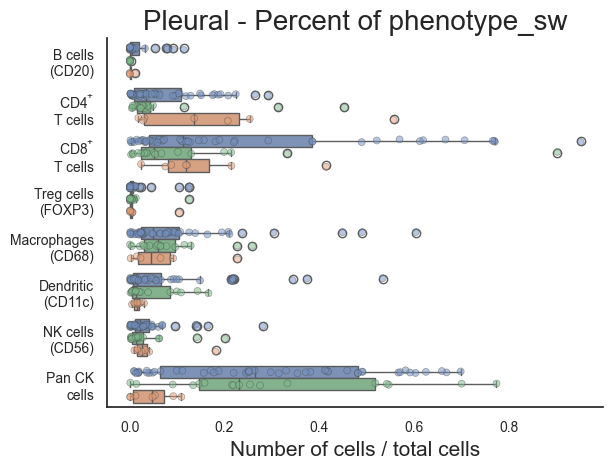

/var/folders/p7/l3vgwn3s1vl6wg6p16kkq0l00000gr/T/ipykernel_35936/3901504436.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


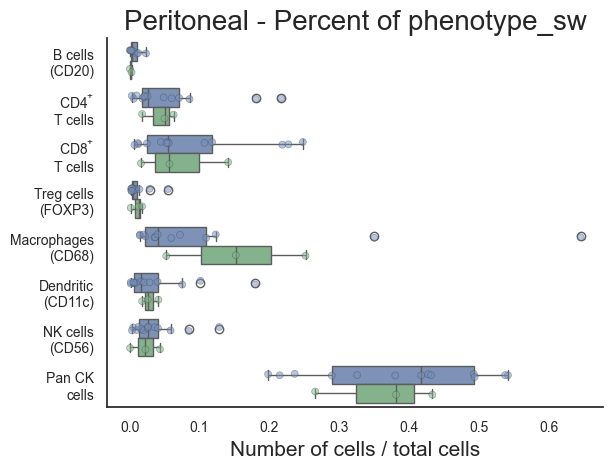

In [6]:
# from utils import box_plot_plus_horizontal

df_feature_ori = pd.read_csv("./data/TMA_data/core_features_allMarkers_withIntensity_MVB_mean.csv")
df_feature_ori.loc[(df_feature_ori['subtype']=='epithelial') | (df_feature_ori['subtype']=='epithelial or epithelioid'), 'subtype' ] = "epithelioid"

markers = ["CD20", "CD4", "CD8", "FOXP3", "CD68", "CD11c", "CD56", "CK"] # unidentified does not have intensity, "Unidentified"]
grouptype = "percent"
cols = [marker+" "+grouptype for marker in markers]
df_feature = df_feature_ori[['MVB','casetype','subtype'] + cols]
# change the column names (remove the grouptype)
df_feature.columns = ['MVB','casetype','subtype'] + markers
df_feature = df_feature.melt(id_vars=['MVB','casetype','subtype'], var_name='phenotype', value_name=grouptype)
df_feature.replace(0, np.nan, inplace=True) #do not plot the density of 0 cores
non_parametric = False
outpath =""

# "Pleural
casetype = "Pleural"
title = f'{casetype} - {grouptype.capitalize()} of phenotype'
    
hue_order=["epithelioid", "biphasic", "sarcomatoid"]
df_plot = df_feature.loc[df_feature['casetype']==casetype,:]
df_plot = df_plot.loc[df_plot['subtype'].isin(hue_order), :]

box_plot_plus_horizontal(outpath, title+"_sw",df_plot, grouptype, 'phenotype', 'subtype', markers, hue_order=hue_order, size=(7,6), short=False, save=False)

casetype = "Peritoneal"
title = f'{casetype} - {grouptype.capitalize()} of phenotype'
hue_order=["epithelioid", "biphasic"]

df_plot = df_feature.loc[df_feature['casetype']==casetype,:]
df_plot = df_plot.loc[df_plot['subtype'].isin(hue_order), :]

box_plot_plus_horizontal(outpath, title+"_sw",df_plot, grouptype, 'phenotype', 'subtype', markers, hue_order=hue_order, size=(14,12), short=False, save=False)
